In [2]:
%load_ext rpy2.ipython
import rpy2.robjects.lib.ggplot2 as ggplot2
import childespy
import numpy as np
import os
import imp
import pandas as pd
import Levenshtein
import itertools

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [3]:
regenerate_cached_phono = False
phono_data_path = 'csv/phono_data.csv'
if (not os.path.exists(phono_data_path)) or regenerate_cached_phono:
    phono = childespy.get_sql_query('select gloss, target_child_name, target_child_age, \
    speaker_code, actual_phonology, model_phonology, transcript_id, utterance_id, \
    token_order, corpus_name, collection_name, language from token where actual_phonology != "" and model_phonology != ""',
        db_version = "2020.1")
    # cache this phonological information locally
    phono.to_csv(phono_data_path, index=False)
else:
    phono = pd.read_csv(phono_data_path, keep_default_na=False, na_values=[''])

In [4]:
# remove cases where one is not set
excludes = ['*','(.)','(..)', '(...)','(....)','(.....)']
phono = phono.loc[~(phono.model_phonology.isin(excludes) |  phono.actual_phonology.isin(excludes))]

In [5]:
phono.shape

(914135, 12)

In [6]:
chi_phono = phono.loc[(phono.speaker_code == 'CHI') & (phono.target_child_age < (365*5))]

In [7]:
chi_phono.shape

(802885, 12)

In [8]:
chi_phono_age = chi_phono[['target_child_age']]
%R -i chi_phono_age

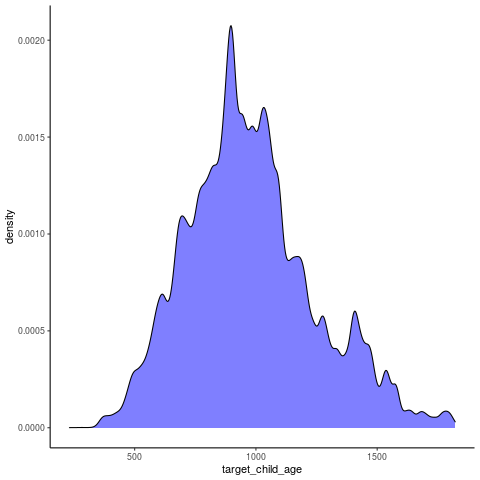

In [9]:
%%R
ggplot(chi_phono_age) + geom_density(aes(x=target_child_age), fill='blue', alpha=.5) + theme_classic()

In [199]:
def lev_wrapper(model_phonology, actual_phonology, normalize=False):
    try: 
        dist = Levenshtein.distance(model_phonology.replace(' ',''),
                        actual_phonology.replace(' ',''))
        if normalize:
            dist = dist / len(model_phonology) # how much of the 
        return(dist)
    except:
        print('Issue calculating Lev distance')
        print(model_phonology)
        print(actual_phonology)
        return(None)

chi_phono['levdist'] = [lev_wrapper(x['model_phonology'], x['actual_phonology'], normalize=True) for x in  chi_phono.to_dict('records')]

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [200]:
chi_phono.columns

Index(['gloss', 'target_child_name', 'target_child_age', 'speaker_code',
       'actual_phonology', 'model_phonology', 'transcript_id', 'utterance_id',
       'token_order', 'corpus_name', 'collection_name', 'language', 'levdist'],
      dtype='object')

In [201]:
chi_mean_levdist = chi_phono.groupby(['transcript_id','corpus_name','collection_name','language',
                  'target_child_name','target_child_age']).levdist.agg(np.mean).reset_index()
chi_mean_levdist = chi_mean_levdist.rename(columns={'levdist': 'mean_levdist'})
chi_sd_levdist = chi_phono.groupby(['transcript_id','corpus_name','collection_name','language',
                  'target_child_name','target_child_age']).levdist.agg(np.std).reset_index()
chi_sd_levdist = chi_sd_levdist.rename(columns={'levdist': 'sd_levdist'})

In [202]:
chi_levdist = chi_mean_levdist.merge(chi_sd_levdist)
chi_levdist.head()

,transcript_id,corpus_name,collection_name,language,target_child_name,target_child_age,mean_levdist,sd_levdist
0,37458,MCF,Biling,por swe,Karin,243.5000,1.037037,0.151807
1,37459,MCF,Biling,por swe,Karin,273.9375,0.931250,0.495381
2,37460,MCF,Biling,por swe,Karin,334.8125,0.727679,0.255918
3,37461,MCF,Biling,swe por,Karin,608.7500,0.546459,0.417893
4,37462,MCF,Biling,swe por,Karin,639.1875,0.630745,0.403633


In [203]:
%R -i chi_levdist

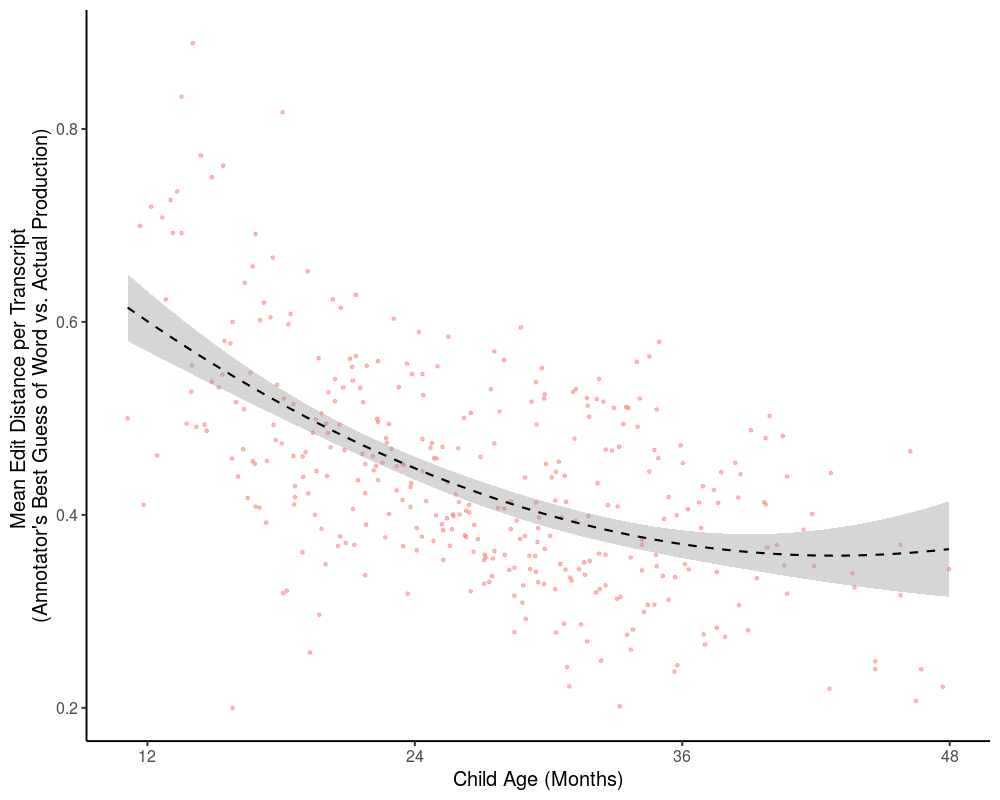

In [237]:
%%R -h 800 -w 1000
chi_levdist$age_in_months = chi_levdist$target_child_age / 30.5
year_intervals_in_months = c(12,24,36,48)

p1 = ggplot(subset(chi_levdist, mean_levdist < 100 & corpus_name == 'Providence')) + geom_point(aes(x=age_in_months, y=mean_levdist, 
color=collection_name), alpha=.5)  + theme_classic(base_size =20) +theme(legend.position="none"
) + geom_smooth(aes(x=age_in_months, y=mean_levdist), linetype='dashed', formula=y ~ poly(
    x, 2, raw=TRUE), method='lm', color='black') + ylab("Mean Edit Distance per Transcript \n(Annotator's Best Guess of Word vs. Actual Production)"
) + xlab('Child Age (Months)') + scale_x_continuous(
    breaks = year_intervals_in_months, labels=year_intervals_in_months
)
ggsave('figures/edit_distances_pvd.pdf', width=8, height=8)
print(p1)

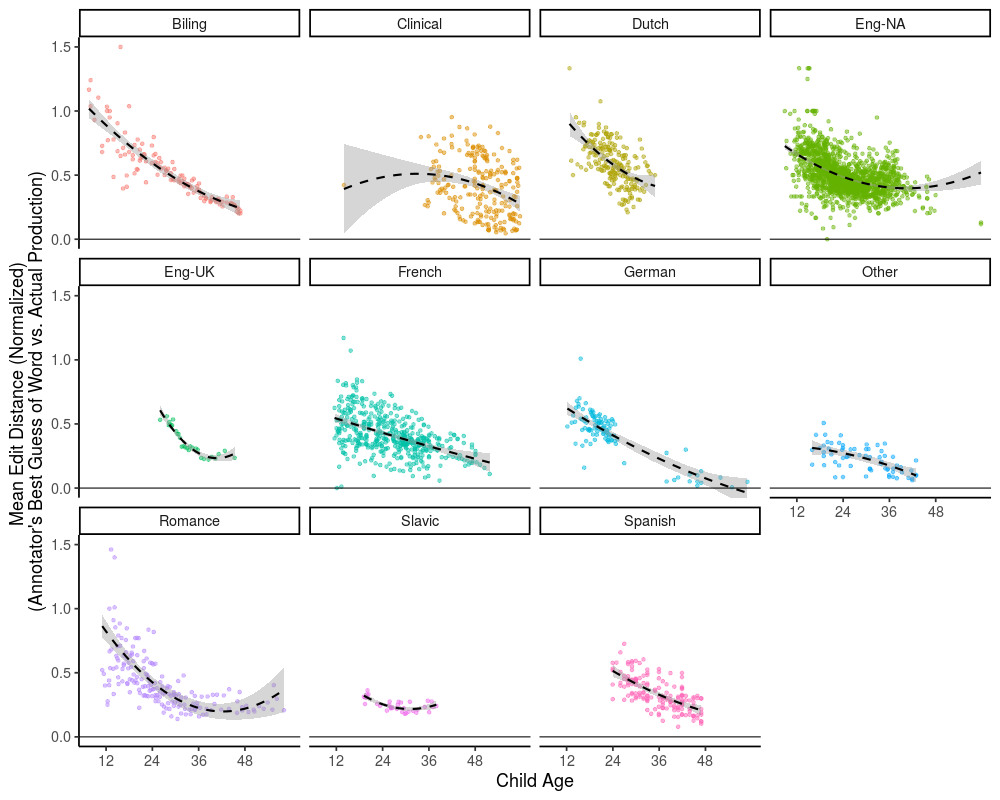

In [227]:
%%R -h 800 -w 1000
chi_levdist$age_in_months = chi_levdist$target_child_age / 30.5
year_intervals_in_months = c(12,24,36,48)

ggplot(subset(chi_levdist, mean_levdist < 100)) + geom_point(aes(x=age_in_months, y=mean_levdist, 
color=collection_name), alpha=.5)  + facet_wrap(~collection_name
) + theme_classic(base_size =18) +theme(legend.position="none"
) + geom_smooth(aes(x=age_in_months, y=mean_levdist), linetype='dashed', formula=y ~ poly(
    x, 2, raw=TRUE), method='lm', color='black') + ylab("Mean Edit Distance (Normalized) \n(Annotator's Best Guess of Word vs. Actual Production)"
) + xlab('Child Age') + geom_hline(yintercept =0) + scale_x_continuous(
    breaks = year_intervals_in_months, labels=year_intervals_in_months
) + coord_cartesian(ylim = c(0,1.5))

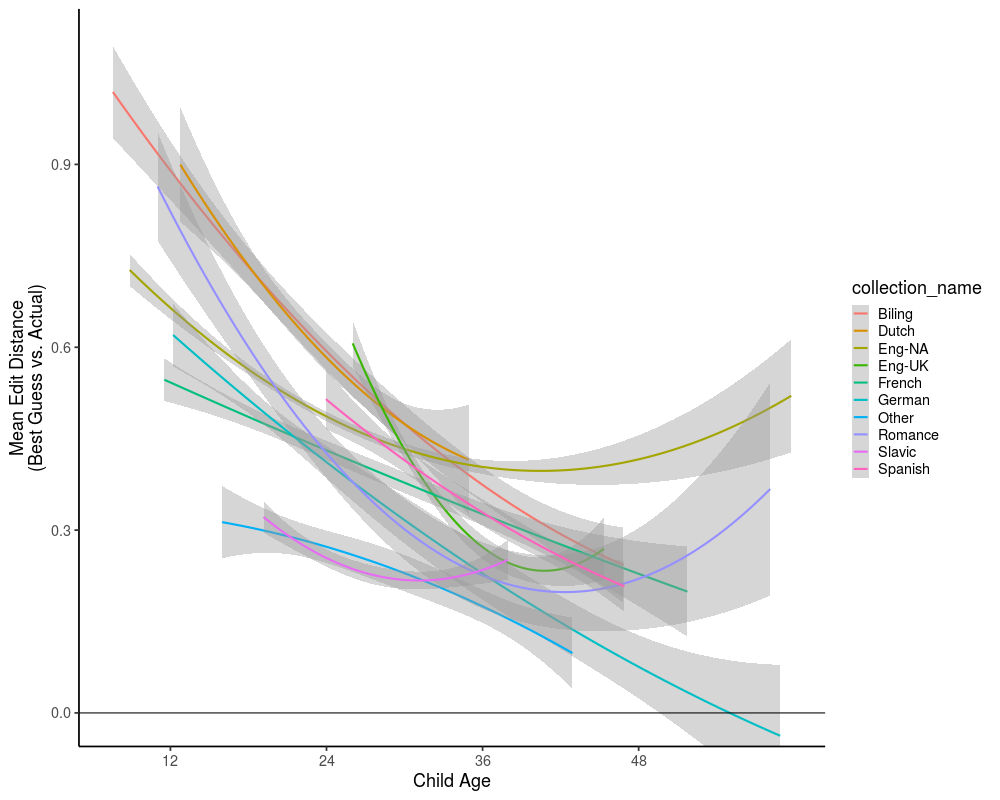

In [20]:
%%R -h 800 -w 1000
ggplot(subset(chi_levdist, mean_levdist < 100 & collection_name != "Clinical")) + theme_classic(
    base_size =18
)  + geom_smooth(aes(x=age_in_months, y=mean_levdist, 
color=collection_name), formula=y ~ poly(x, 2, raw=TRUE), method='lm'
) + ylab('Mean Edit Distance\n(Best Guess vs. Actual)') + xlab('Child Age'
) + scale_x_continuous(breaks = year_intervals_in_months, labels=year_intervals_in_months
) + geom_hline(yintercept =0) + coord_cartesian(ylim=c(0,1.1))

#+ geom_point(aes(x=target_child_age, y=mean_levdist, color=collection_name), alpha=.5)

In [21]:
chi_phono.loc[(chi_phono.collection_name == "Eng-NA") & (chi_phono.target_child_age > 40*30.5)]\
.to_csv('csv/EngNAOver40months.csv', index=False)
# not a model mismatch

# Model Probabilities

In [ ]:
# Restorations are higher probability under a language model than literal
# interpretations of children's productions

In [ ]:
# Use CELEX to map actual phono back to other sentences
# get probability of all possible alternatives
# compare with the probability of the gloss

#Phonology to orthography mapping is difficult
# measure the total number of tokens missing
# CELEX hard with agglutinative morphology. Only English works -- highly analytic morphology
# is there a model that works with the IPA representations directly 
    -- Character-level IPA model

In [ ]:
#[X] what is the format for CELEX?
#[X] need the phonology of the whole utterance
#[X] Need CELEX compare this to the detection performance in CMU
    #[X] "it's" for example -- should be okay to run everything
# [X] Need a mapping from CELEX to IPA
# [X] Produce a map that goes from each IPA representation to all orthographic representations
# [ ] deal with edge cases in the IPA translation
# [ ] create a lattice from IPA translation to enumerate possible interpretations

In [ ]:
# goal is to generate a lattice of possible orthographic sequences for a given IPA sequence

In [29]:
to_remove = '/home/stephan/python/phonecodes/src'
if to_remove in sys.path:
    sys.path.remove(to_remove)
sys.path

['/home/stephan/notebooks/child-directed-listening',
 '/home/stephan/notebooks/child-directed-listening/lib/python37.zip',
 '/home/stephan/notebooks/child-directed-listening/lib/python3.7',
 '/home/stephan/notebooks/child-directed-listening/lib/python3.7/lib-dynload',
 '/usr/lib/python3.7',
 '',
 '/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages',
 '/home/stephan/python/mlm-scoring/src',
 '/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/IPython/extensions',
 '/home/stephan/.ipython',
 '/home/stephan/python',
 '/home/stephan/python',
 '/home/stephan/python/',
 '/home/stephan/python',
 '/home/stephan/python/',
 '/home/stephan/python']

In [36]:
from importlib import reload  
import sys
sys.path.append('/home/stephan/python')
from pyCelex2 import pyCelex
reload(pyCelex)
sys.path.append('/home/stephan/python/phonecodes/src')
import phonecodes

In [32]:
en_celex = pyCelex.buildWordFormDict('/shared_hd0/corpora/CELEX2/','ENGLISH')

Building wordform dictionary from /shared_hd0/corpora/CELEX2//ENGLISH
Reading lemmas...
(52447 lemmas)
Reading morphology...
(160595 wordforms)
Reading phonology...
(91772 orthographies)


In [41]:
def cleanup(ipa):
    return(ipa.replace('.',''))
    
def get_ipa_for_ortho_celex(target_word, celex_obj, language):
    prons = celex_obj[target_word][0].pronunciations
    possible_ipa_forms = []
    for pron in prons:
        subprons = str(pron).split(" / ")
        disc = subprons[0].replace("Pronunciation: ","").replace("'","")
        ipa = phonecodes.disc2ipa(disc, language)
        if ipa[-1] == 'R':        
            # if the word ends in a possible linking R
            possible_ipa_forms.append(ipa[0:(len(ipa)-1)])
            ipa_list = list(ipa)
            ipa_list[-1] = 'r'
            ipa = ''.join(ipa_list)        
        possible_ipa_forms.append(ipa)
        possible_ipa_forms = [cleanup(x) for x in possible_ipa_forms]
    return(possible_ipa_forms)

In [42]:
get_ipa_for_ortho_celex("they're", en_celex, 'ENGLISH')

['ðeɪə', 'ðeɪər', 'ðɛə', 'ðɛər']

In [46]:
# for each orthographic entry in CELEX, get all IPA forms
ortho_keys = [x for x in en_celex.keys()]
ipa_to_ortho_en = pd.concat([pd.DataFrame({'ipa':get_ipa_for_ortho_celex(x, en_celex, 'ENGLISH'),
    'ortho':x}) for x in ortho_keys])

# then index on the IPA forms, and get all ortho forms for each ipa form
ortho_to_ipa_en = ipa_to_ortho_en.groupby('ipa').ortho.agg(np.unique).reset_index()
ipa_to_ortho_en_dict =  dict(zip(ortho_to_ipa_en['ipa'],ortho_to_ipa_en['ortho']))

In [47]:
# translate IPA into orthographic forms
en_chi_phono = chi_phono.loc[chi_phono.collection_name == 'Eng-NA']
en_chi_phono.head(5)

,gloss,target_child_name,target_child_age,speaker_code,actual_phonology,model_phonology,transcript_id,utterance_id,token_order,corpus_name,collection_name,language,levdist
162470,yyy,Naima,609.7500,CHI,hɛhɪ,*vv,42409,17015713,1,Providence,Eng-NA,eng,1.333333
162478,I,Julia,693.6250,CHI,ə,a,41544,16650674,1,Goad,Eng-NA,eng,1.000000
162479,a,Sonya,826.8125,CHI,ðæ,a,41587,16659604,1,Goad,Eng-NA,eng,2.000000
162480,I,Julia,1192.0625,CHI,aj,a,41569,16658519,1,Goad,Eng-NA,eng,1.000000
162481,I,Julia,1192.0625,CHI,aj,a,41569,16659995,1,Goad,Eng-NA,eng,1.000000


In [48]:
en_chi_phono = en_chi_phono.sort_values(by='token_order', ascending=True)
index_vars = ['utterance_id', 'target_child_name', 'target_child_age',
     'speaker_code', 'transcript_id', 'corpus_name', 'collection_name', 'language']
utts = en_chi_phono.groupby(index_vars).actual_phonology.agg( lambda x: ' '.join(x)).reset_index()
utts['actual_phonology_list'] = [x.split(' ') for x in utts['actual_phonology']]

In [155]:
manual_map = {
    "no": "no",
    "jæ": "yeah",
    "mɑmi": "mommy",
    "tu": "two",
    "ɛn": "in",
    "go": "go",
    "ɑn": "on",
    "tə": "to",
    "ɪs": "is",
    "ʌm": "am",
    "wən": "one",
    "ai": "i",
    "mɑm": "mom",
    "dædi": "daddy",
    "wʌt": "what",
    "jɛ": "you",
    "wɛ": "were",
    "æ̃n": ["an","and"],
    "wɑn": "one",
    "noː": "no",
    "wʌs": "was",
    "wʌts": "what's",
    "okeɪ": "okay",
    "beɪbi": "baby",
    "ɑf": "of"
}

def ortho_detector(phono_list, ipa_to_ortho_map):
    rlist = []
    for phono_item in phono_list:
        try:
            transcriptions = ipa_to_ortho_map[phono_item]
            rlist.append(transcriptions)
        except:
            try:
                # check if the lengthened form is present
                transcriptions = manual_map[phono_item]
                rlist.append(transcriptions)
            except:
                try:
                    transcriptions = ipa_to_ortho_map[phono_item+'ː']
                    rlist.append(transcriptions)
                except:
                    pass
    return(rlist)
    

In [156]:
utts['ortho_from_ipa'] = [ortho_detector(x, ipa_to_ortho_en_dict) for x in  
    utts['actual_phonology_list']]
utts['num_ipa_words'] = [len(x) for x in  
    utts['actual_phonology_list']]
utts['num_found_ortho_words'] = [len(x) for x in  
    utts['ortho_from_ipa']]

In [157]:
# measure the coverage in utterances
print('Total number of tokens found:')
print(np.sum(utts.num_found_ortho_words) / np.sum(utts.num_ipa_words))
print('Proportion of complete utterances found')
utts['all_found'] = utts.num_found_ortho_words == utts.num_ipa_words
print(np.mean(utts['all_found']))

Total number of tokens found:
0.4417745074849745
Proportion of complete utterances found
0.20740084522996935


In [136]:
utts.loc[utts.all_found].sort_values(by=['num_found_ortho_words'], ascending = False).head(40)

,utterance_id,target_child_name,target_child_age,speaker_code,transcript_id,corpus_name,collection_name,language,actual_phonology,actual_phonology_list,ortho_from_ipa,num_ipa_words,num_found_ortho_words,all_found
21275,16811555,Alex,1145.1875,CHI,42246,Providence,Eng-NA,eng,wi dɪd ɪt wi dɪd ɪt wi dɪd ɪt wi dɪd ɪt wi dɪd...,"[wi, dɪd, ɪt, wi, dɪd, ɪt, wi, dɪd, ɪt, wi, dɪ...","[[we, wee], did, it, [we, wee], did, it, [we, ...",30,30,True
48073,16949003,Lily,734.5000,CHI,42329,Providence,Eng-NA,eng,ɑː lɑ lɑː lɑ lɑ lɑ lɑ lɑ lɑ lɑ lɑ lɑ lɑ lɑ lɑ lɑ,"[ɑː, lɑ, lɑː, lɑ, lɑ, lɑ, lɑ, lɑ, lɑ, lɑ, lɑ, ...","[[R, ah, are, our, r], la, la, la, la, la, la,...",16,16,True
10389,16760627,Alex,585.3125,CHI,42208,Providence,Eng-NA,eng,bɑ bɑ bɑ bɑ bɑ bɑ bɑ bɑ bɑ bɑ bɑ bɑ bɑ bɑ,"[bɑ, bɑ, bɑ, bɑ, bɑ, bɑ, bɑ, bɑ, bɑ, bɑ, bɑ, b...","[[Bar, baa, bah, bar], [Bar, baa, bah, bar], [...",14,14,True
81706,17067967,Naima,837.8125,CHI,42437,Providence,Eng-NA,eng,ə bʊk ə bʊk ə bʊk ə bʊk ə bʊk ə bʊk ə bʊk,"[ə, bʊk, ə, bʊk, ə, bʊk, ə, bʊk, ə, bʊk, ə, bʊ...","[['re, a, er, her, o', of, or], book, ['re, a,...",14,14,True
69007,17024031,Naima,519.4375,CHI,42399,Providence,Eng-NA,eng,blu blu blu blu blu blu blu blu blu blu blu bl...,"[blu, blu, blu, blu, blu, blu, blu, blu, blu, ...","[[blew, blue], [blew, blue], [blew, blue], [bl...",13,13,True
113251,17197684,William,868.2500,CHI,42548,Providence,Eng-NA,eng,du du du du duː du du duː du du du du du,"[du, du, du, du, duː, du, du, duː, du, du, du,...","[do, do, do, do, do, do, do, do, do, do, do, d...",13,13,True
77268,17053463,Naima,760.9375,CHI,42429,Providence,Eng-NA,eng,ə lu ɪ lu ɪ lu ə lu ə lu ə lu,"[ə, lu, ɪ, lu, ɪ, lu, ə, lu, ə, lu, ə, lu]","[['re, a, er, her, o', of, or], [lieu, loo], h...",12,12,True
10401,16760863,Alex,585.3125,CHI,42208,Providence,Eng-NA,eng,bɑ bɑ bɑ bɑ bɑ bɑ bɑ bɑ bɑ bɑ bɑ bɑ,"[bɑ, bɑ, bɑ, bɑ, bɑ, bɑ, bɑ, bɑ, bɑ, bɑ, bɑ, bɑ]","[[Bar, baa, bah, bar], [Bar, baa, bah, bar], [...",12,12,True
81969,17068881,Naima,897.6875,CHI,42445,Providence,Eng-NA,eng,ə dɪp ə zɪp ə zæp ə zɪp ə zɪp ə zɪp,"[ə, dɪp, ə, zɪp, ə, zæp, ə, zɪp, ə, zɪp, ə, zɪp]","[['re, a, er, her, o', of, or], dip, ['re, a, ...",12,12,True
12082,16774551,Alex,791.3750,CHI,42222,Providence,Eng-NA,eng,bi bi bi bi bi biː bi bi bi bi biː,"[bi, bi, bi, bi, bi, biː, bi, bi, bi, bi, biː]","[[B, b, be, bee], [B, b, be, bee], [B, b, be, ...",11,11,True


In [ ]:
# a lot of these are garbage
# lots of sentence repetitions
# tʊ -> two
# ɡʌnə -> gunner
# many utterances include multiple sentences

In [ ]:
# [X] restore long vowls -- best to test both
# [ ] syllabic R and N
# [ ] stress marks: " and '
# [ ] ɻ

In [137]:
ortho_detector(['ju', 'kæt'], ipa_to_ortho_en_dict)

[array(['U', 'ewe', 'u', 'yew', 'you'], dtype=object), 'cat']

In [158]:
get_ipa_for_ortho_celex("iranian", en_celex, 'ENGLISH')

['ɪreɪnjən',
 'aɪreɪnjən',
 '"aɪəreɪnjən',
 'ɪreɪnɪən',
 'aɪreɪnɪən',
 '"aɪəreɪnɪən']

In [147]:
ortho_detector(['is'], ipa_to_ortho_en_dict)

[]

In [140]:
# Extend the dataset by frequency
ipa_freqs = en_chi_phono.groupby(['actual_phonology']).gloss.agg(np.size).reset_index()
ipa_freqs = ipa_freqs.sort_values(by='gloss', ascending=False)
ipa_freqs['ortho_options'] = [ortho_detector([x], ipa_to_ortho_en_dict)
    for x in ipa_freqs.actual_phonology]

ipa_freqs.to_csv(
    'csv/ipa_coverage_test.csv')

In [141]:
ipa_freqs.head(5)

,actual_phonology,gloss,ortho_options
47884,ə,10909,"[['re, a, er, her, o', of, or]]"
272,aɪ,6440,"[[I, eye, i]]"
26422,no,5957,[]
8023,də,4918,[]
16441,ju,3851,"[[U, ewe, u, yew, you]]"


### Assign Probabilities to Candidate Sequences

In [53]:
sys.path.append('/home/stephan/python/mlm-scoring/src/')
from mlm.scorers import MLMScorer, MLMScorerPT, LMScorer
from mlm.models import get_pretrained

import mxnet as mx
ctxs = [mx.cpu()]

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/mxnet/optimizer/optimizer.py:167: UserWarning: WARNING: New optimizer gluonnlp.optimizer.lamb.LAMB is overriding existing optimizer mxnet.optimizer.optimizer.LAMB
  Optimizer.opt_registry[name].__name__))


In [55]:
model, vocab, tokenizer = get_pretrained(ctxs, 'bert-base-en-cased')
scorer = MLMScorer(model, vocab, tokenizer, ctxs)

In [60]:
test = [['this'], ['tail', 'tale'], ['fits'], ['in', 'inn']]
# enumerate the paths through these options


products = list(itertools.product(*test))
test_sentences =  [' '.join(x) for x in products]
df = pd.DataFrame(test_sentences)
df['score'] = scorer.score_sentences(test_sentences)
df.sort_values(by='score', ascending=False)

,0,score
2,this tale fits in,-31.532228
0,this tail fits in,-33.227505
3,this tale fits inn,-38.998445
1,this tail fits inn,-47.665850


# Gloss Probabilities vs. Edit Distances

In [ ]:
# get the glosses for the utterances
# measure the string edit distance between the true gloss and IPA

In [174]:
model_phono = en_chi_phono.groupby(index_vars).model_phonology.agg( 
    lambda x: ' '.join(x)).reset_index()
model_phono['model_phonology_list'] = [x.split(' ') for x in 
     model_phono['model_phonology']]

glosses = en_chi_phono.groupby(index_vars).gloss.agg( 
    lambda x: ' '.join(x)).reset_index()
glosses['gloss_list'] = [x.split(' ') for x in 
     glosses['gloss']]


In [175]:
merged_utts = utts.merge(model_phono).merge(glosses)

In [176]:
merged_utts.iloc[1]

utterance_id                           16645564
target_child_name                             E
target_child_age                        281.938
speaker_code                                CHI
transcript_id                             41232
corpus_name                             Inkelas
collection_name                          Eng-NA
language                                    eng
actual_phonology                             bɑ
actual_phonology_list                      [bɑ]
ortho_from_ipa           [[Bar, baa, bah, bar]]
num_ipa_words                                 1
num_found_ortho_words                         1
all_found                                  True
model_phonology                             bɑl
model_phonology_list                      [bɑl]
gloss                                      ball
gloss_list                               [ball]
Name: 1, dtype: object

In [177]:
merged_utts['score'] = scorer.score_sentences([x+'.' for x in merged_utts.gloss])
# takes a little while

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/gluonnlp/data/sampler.py:354: UserWarning: Some buckets are empty and will be removed. Unused bucket keys=[65, 72]
  str(unused_bucket_keys))


In [197]:
merged_utts[['model_phonology','actual_phonology']][1:100]

,model_phonology,actual_phonology
1,bɑl,bɑ
2,bɑl,bwɑ
3,haɪ,hæːɪ
4,ðɛɹ,dæː
5,bɑl,bɣɑ
...,...,...
95,ɡuːs,duh
96,hɛloʊ,oːwoʊ
97,fɪʃ,ʂiʃ
98,θæŋk juː,hæʊ hoʷ


In [205]:
merged_utts['levdist'] = [lev_wrapper(x['model_phonology'], x['actual_phonology'], 
    normalize=True) for x in  merged_utts.to_dict('records')]

In [206]:
merged_utts_short = merged_utts[['target_child_age','score', 'levdist']]
%R -i merged_utts_short

In [ ]:
%%R
# utterance probability vs. noramlized levenshtein distance
ggplot(merged_utts_short) + geom_hex(aes(x = -1*score,
y = levdist)) + theme_classic() + xlab('Utterance Negative Log Probability') + ylab(
    'Normalized Edit Distance') + theme(legend.position="none")

In [209]:
merged_utts_short

Index(['target_child_age', 'score', 'levdist'], dtype='object')

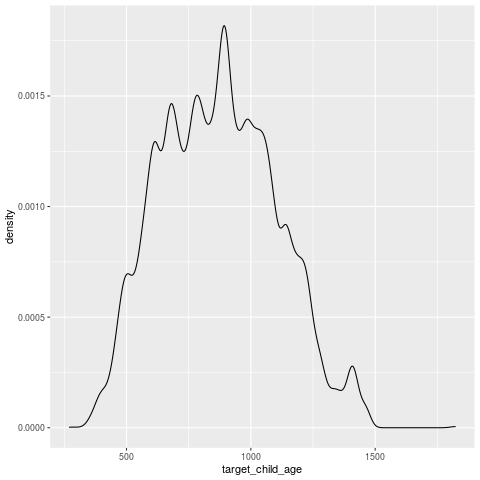

In [216]:
%%R
ggplot(merged_utts_short) + geom_density(aes(x=target_child_age))

In [217]:
%%R
merged_utts_short$age_interval = floor(merged_utts_short$target_child_age / (30.5 * 12))

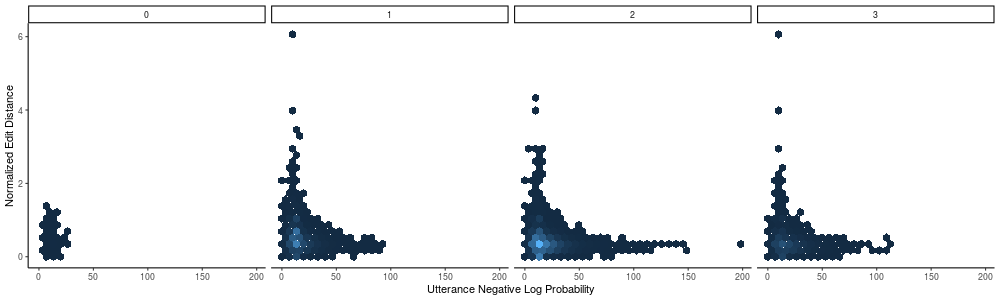

In [222]:
%%R -w 1000 -h 300
# also gloss probability by age
ggplot(subset(merged_utts_short, age_interval <= 3)) + geom_hex(aes(x = -1*score,
y = levdist)) + theme_classic() + xlab('Utterance Negative Log Probability') + ylab(
    'Normalized Edit Distance') + theme(legend.position="none")  + facet_wrap(~age_interval,
    ncol= 4)

In [ ]:
# may need to fine-tune the BERT model on CHILDES for xxx and yyy etc.
# Cache merged utts

# Todo

In [ ]:
[ ] Try the PFST rather than unweighted Levenshtein distance
[ ] Limit to cases where the adult uses the same word in the surrounding context
[ ] General question: how good are these approximations vs. alternatives